In [1]:
from qsharp_bridge import *
from qsharp_widgets import Circuit
import matplotlib.pyplot as plt
import os
import json
import requests
import qsharp

from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [17]:
def visualize(data):
    pairs = ['[{}, {}]'.format(*pair) for pair in data['result']['c']]
    counts = {pair: pairs.count(pair) for pair in set(pairs)}

    plt.figure(figsize=(4, 3))
    plt.bar(counts.keys(), counts.values())
    plt.show()

In [14]:
code = """@EntryPoint()
operation Run() : (Result, Result) {
    use (control, target) = (Qubit(), Qubit());
    H(control);
    CNOT(control, target);

    let resultControl = M(control);
    let resultTarget = M(target);
    return (resultControl, resultTarget);
}
"""

qsharp.eval(code)

In [15]:
Circuit(qsharp.circuit("Run()"))

Circuit(circuit_json='{"operations":[{"gate":"H","targets":[{"qId":0,"type":0}]},{"gate":"X","isControlled":tr…

In [22]:
qasm_code = qasm2(code)
print(qasm_code)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
cx q[0], q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];



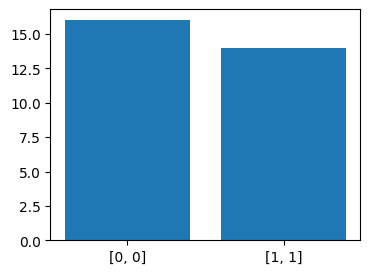

In [ ]:
req = {
    'script': qasm_code,
    'count': 30
}

result = requests.post('<path to QASM simulator>', json=req, verify=False)
data = json.loads(result.content)
visualize(data)